# MIS 583 Assignment 5-2(bouns): Generative Adversarial Network(GAN)

This tutorial was originally written by [Nathan Inkawhich](https://github.com/inkawhich) for PyTorch Offical Tutorial.

This version has been adapted by [Yao-Rong Chen](https://github.com/teacher144123/) for NSYSU mis 583 assigment.


Refrence:
- DCGAN - PyTorch offical tutorial  
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- Self-Normalizing Neural Networks  
https://arxiv.org/abs/1706.02515
- Relativistic GAN  
https://arxiv.org/abs/1807.00734

Tutorial or Source code:
- SELU make funs great again  
https://towardsdatascience.com/selu-make-fnns-great-again-snn-8d61526802a9
- Relativistic GAN offical GitHub **(important)**  
https://github.com/AlexiaJM/RelativisticGAN
- third party Relativistic repo - ririw  
https://github.com/ririw/Relativistic-GAN/blob/master/relgan/trainer.py


## Generative Adversarial Network(GAN)

"GAN and its variations that are now being proposed is the most interesting idea in the last 10 years in ML, in my opinion." LeCun has ever said.

GAN was designed by Ian Goodfellow in 2014 is an approach contains generator and discirminator.

Though originally proposed as a form of generative model for **unsupervised learning**, GANs have also proven useful for **semi-supervised learning**, **fully supervised learning** and **reinforcement learning**.



### What is GAN

GAN contains generator and discirminator.

Generator's primary goal is fool the discriminator, make loss of discriminator maximum.

In contrast, disciminator's main goal is corretly classifiy whether  a image(or data) is real(from original dataset) or fake(made by generator).

In this tutorial, we will cover:
- GAN
- DCGAN
- SELU
- Relativistic GAN
- or any advanced GAN you interested in

This assignment will walk you through implementing a DCGAN sing the CelebA dataset in PyTorch and apply some advanced modifications.

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

We use `python 3.6.9`, `torch==1.7.0` and `torchvision==0.8.1`

In [ ]:
!python3 --version
!pip3 freeze | grep torch

Python 3.6.9
torch==1.7.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101


## Prepare Data

We use [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset from cuhk university.

**Abstrct**  

CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations.  

The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including

- 10,177 number of identities,

- 202,599 number of face images, and

- 5 landmark locations, 40 binary attributes annotations per image.

- Original Size: 218x178

### Get Data

請先到共用雲端硬碟將檔案`celeba_dataset.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1CYHiydUBHbnTKmZnL7M7oT_FArKMeSo-/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

執行此段後點選出現的連結，允許授權後，複製授權碼，貼在空格中後按下ENTER，即完成與雲端硬碟連結。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzip Data

解壓縮 `celeba_dataset.zip` 後可以發現裡面有一個資料夾和五個 .txt 檔。

- `img_align_celeba`: contain 202599 images.
- `list_eval_partition`: image id partition for train, val and test.  
- ...

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [ ]:
!mkdir data
!unzip -qq -n ./drive/My\ Drive/celeba_dataset.zip -d data/celeba

### Load Data

In [ ]:
import torch
import numpy as np 
import torch.utils.data as data
from torchvision import transforms, datasets

We can load it just use torchvision

In [ ]:
def get_celeba(root, split, download=False):
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
    ])
    return datasets.CelebA(root, split=split, transform=transform,
        download=download)

def get_data():
    dataset_train = get_celeba('./data', 'train',)
    dataset_test = get_celeba('./data', 'test')
    print('train', len(dataset_train))
    print('test', len(dataset_test))
    return dataset_train, dataset_test

dataset_train, dataset_test = get_data()

train 162770
test 19962


In [ ]:
batch_size = 32
img_size = 64
train_data = data.DataLoader(dataset_train, batch_size=batch_size,
                             drop_last=True, shuffle=True)
test_data = data.DataLoader(dataset_test, batch_size=batch_size,
                             drop_last=True)

Let's sample some images and plot them.

In [ ]:
import matplotlib.pyplot as plt

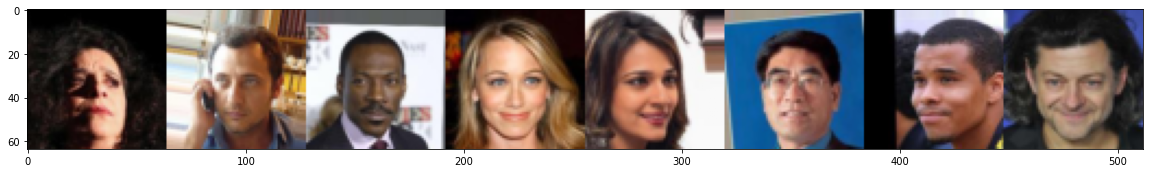

In [ ]:
def plot_imgs(img, save_file=False, file_name='out'):
    img = img.permute(1, 2, 0, 3).reshape(3, img_size, -1)
    img = (img + 1) / 2
    plt.figure(figsize=(20,10))
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    if save_file:
        plt.savefig(file_name)

plot_imgs(next(iter(train_data))[0][:8])

## Build Model
### DCGAN

[DCGAN](https://arxiv.org/abs/1511.06434) (Deep Convolutional Generative Adversarial Network) was proposed in 2015.

It use ConvTransposed(逆捲積) to build generator.

Discriminator is normal classification using Convolution.

![](https://i.imgur.com/NhERHis.png)

**DCGAN has been a excellent base strucutre of GAN using convolution.**


### SELU

There are some disadvantages in DCGAN.  
DCGAN can't be trained with high learn rate, it is easy to cause gradient vanishing.  
Recently, some research change the loss function or activation to increase the stability of GAN.    
**SELU** is a activation that was proved outperform many existing methods in Feed-Forward Neural Network.  
High-resolution DCGAN paper mentioned BatchNorm + ReLU could be replaced with SELU.

$$
\text{selu}(x) = \lambda \left\{
\begin{aligned}
    & x & if & x > 0 \\
    & \alpha e^x - \alpha & if & x \leq 0
\end{aligned}
\right. \\
\alpha = 1.6732, \lambda = 1.0507
$$


### Relativistic GAN

Relativistic GAN was proprosed in 2018.  
Old GAN discriminator only tend to make fake data more similar to real data.  
Ideal generator should also make real data fake(lost piece of original GAN) and make fake data real(original GAN).  
It will increase stability and coverage into lower reconstruction loss.

(A) 是如果用 divergence minimization 可以達到的效果，(B) 是目前 GAN 實際上用 loss 訓練，(C) 是 Relativistic GAN 的理想的優化

![](https://i.imgur.com/JxiCksr.png)

More detail please check out paper

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

latent_dim = 100
g_hidden = 128 # hidden dim of generator
d_hidden = 128 # hidden dim of discriminator

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # ---------- You Should Modify ----------
        # TODO: add activation
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, g_hidden * 8,
                kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(g_hidden * 8),
            nn.SELU(g_hidden * 8),
            # --> some regularization and activation
            # shape is (g_hidden*8, 4, 4),

            nn.ConvTranspose2d(g_hidden * 8, g_hidden * 4,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(g_hidden * 4),
            nn.SELU(g_hidden * 4),
            # --> some regularization and activation
            # shape is (g_hidden*4, 8, 8),

            nn.ConvTranspose2d(g_hidden * 4, g_hidden * 2,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(g_hidden * 2),
            nn.SELU(g_hidden * 2),
            # --> some regularization and activation
            # shape is (g_hidden*2, 16, 16),

            nn.ConvTranspose2d(g_hidden * 2, g_hidden,
                kernel_size=4, stride=2, padding=1, bias=False),
            # --> some regularization and activation
            # shape is (g_hidden, 32, 32),
            nn.BatchNorm2d(g_hidden),
            nn.SELU(g_hidden),
            nn.ConvTranspose2d(g_hidden, 3,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # shape is (3, 64, 64),
        )

    def forward(self, x):
        output = self.main(x)
        return output

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # ---------- You Should Modify ----------
        # TODO: add activation
        self.main = nn.Sequential(
            nn.Conv2d(3, d_hidden,
                kernel_size=4, stride=2, padding=1, bias=False),
            # --> some regularization and activation
            nn.BatchNorm2d(d_hidden),
            nn.SELU(d_hidden),
            # shape is (d_hidden, 32, 32),

            nn.Conv2d(d_hidden, d_hidden * 2,
                kernel_size=4, stride=2, padding=1, bias=False),
            # --> some regularization and activation
            nn.BatchNorm2d(d_hidden*2),
            nn.SELU(d_hidden*2),
            # shape is (d_hidden * 2, 16, 16),

            nn.Conv2d(d_hidden * 2, d_hidden * 4,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(d_hidden*4),
            nn.SELU(d_hidden*4),
            # --> some regularization and activation
            # shape is (d_hidden * 4, 8, 8),

            nn.Conv2d(d_hidden * 4, d_hidden * 8,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(d_hidden*8),
            nn.SELU(d_hidden*8),

            # --> some regularization and activation
            # shape is (d_hidden * 8, 4, 4),
            nn.Conv2d(d_hidden * 8, 1,
                kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
            # shape is (1, 1, 1)
        )

    def forward(self, x):
        output = self.main(x)
        return output.view(-1, 1).squeeze(1)

def weights_init(m):
    classname = m.__class__.__name__
    if 'Conv' in classname:
        torch.nn.init.normal_(m.weight, 0.0, 0.5 / np.sqrt(m.weight.numel()))
        #torch.nn.init.normal_(m.weight, 0.0, 0.2)
    elif classname.find('BatchNorm') != -1:
        size = m.weight.size()
        print(size)
        fan_in = size[0]
        torch.nn.init.normal_(m.weight, 1.0, 1.0 / np.sqrt(fan_in))
        torch.nn.init.zeros_(m.bias)
    """
    if 'Conv' in classname:
        ##conv_layer.weight.data.normal_(0.0, )
        torch.nn.init.normal_(m.weight, 0.0, np.sqrt(1/(4*4)))
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)
    """


### Test Model
Let's test our model output shape with simulated data input.

In [ ]:
def test_model():
    net_d = Discriminator()
    net_g = Generator()

    x = torch.rand(16, latent_dim, 1, 1)

    out = net_g(x)
    print(out.shape)
    out2 = net_d(out)
    print(out2.shape)
test_model()

torch.Size([16, 3, 64, 64])
torch.Size([16])


GAN is **computation consummed**.  
Adjust your parameter depends on your resources.

In [ ]:
# Hyper-Parameter setting
lr = 2e-4
beta1 = 0.5
start_epoch = 1
max_epoch = 3
dataset = train_data
# Suggestted setting
# train_data run 3 epoch
# test_data run 30 epoch

import os
os.makedirs('ckpts', exist_ok=True)
os.makedirs('out_imgs', exist_ok=True)

In [ ]:
device = torch.device('cuda')

net_g = Generator().to(device)
net_g.apply(weights_init) # apply weight init

net_d = Discriminator().to(device)
net_d.apply(weights_init) # apply weight init

criterion = nn.BCELoss() #nn.BCEWithLogitsLoss()##

optim_d = torch.optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.99))
optim_g = torch.optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.99))

ConvTranspose2d
BatchNorm2d
torch.Size([1024])
SELU
ConvTranspose2d
BatchNorm2d
torch.Size([512])
SELU
ConvTranspose2d
BatchNorm2d
torch.Size([256])
SELU
ConvTranspose2d
BatchNorm2d
torch.Size([128])
SELU
ConvTranspose2d
Tanh
Sequential
Generator
Conv2d
BatchNorm2d
torch.Size([128])
SELU
Conv2d
BatchNorm2d
torch.Size([256])
SELU
Conv2d
BatchNorm2d
torch.Size([512])
SELU
Conv2d
BatchNorm2d
torch.Size([1024])
SELU
Conv2d
Sigmoid
Sequential
Discriminator


Make some fixed noise.  
To see evolutions of our generator model.  
And labels filled with 0 and 1 for training.

In [ ]:
fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
real_label = torch.ones(batch_size, device=device).float()
fake_label = torch.zeros(batch_size, device=device).float()

### Training Loop
Start training!

Training section of DCGAN can be split into two update stage and three parts.

**First**, we feed discirminator some true images and label 1.

**Second**, discriminator is trained with fake images generated by generator model and label 0.

Then, we do one discriminator optimizer step.

**Third**, we will make generator make some fake images and throw them into discriminator with true label 1 try to fool the discriminator.

Finally, generator optimizer update once. 

<font color="red">**BUT, remember Relativitistic GAN have different updated stage**</font>


[1/3 - 0/5086] Loss_D: 1.4829 Loss_G: 12.3655


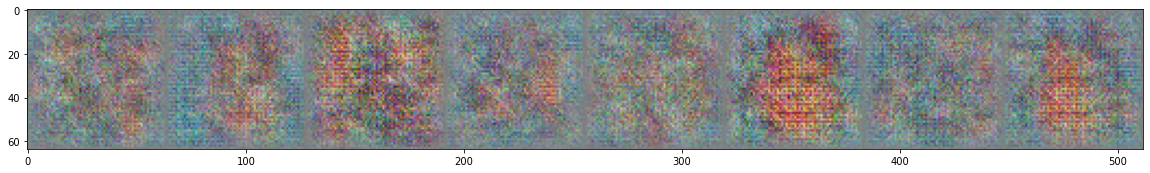

[1/3 - 1017/5086] Loss_D: 1.3977 Loss_G: 1.2274


<Figure size 432x288 with 0 Axes>

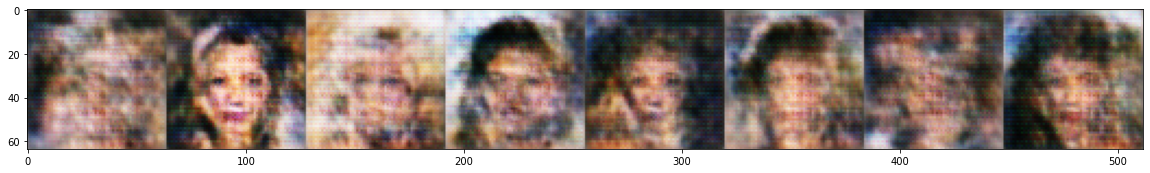

[1/3 - 2034/5086] Loss_D: 1.2468 Loss_G: 1.2076


<Figure size 432x288 with 0 Axes>

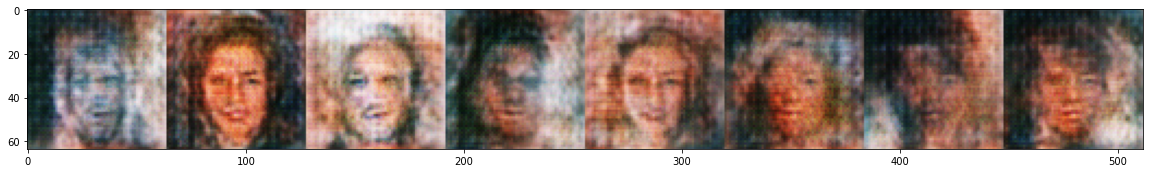

[1/3 - 3051/5086] Loss_D: 1.3124 Loss_G: 2.6804


<Figure size 432x288 with 0 Axes>

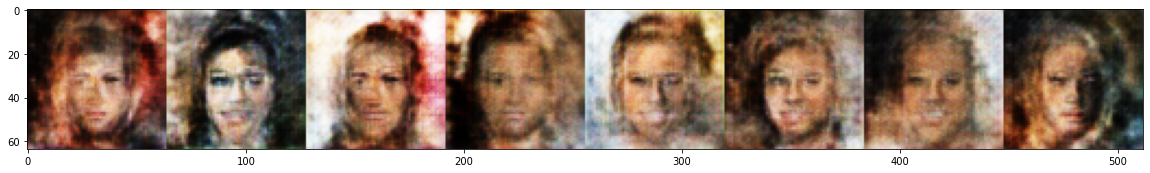

[1/3 - 4068/5086] Loss_D: 0.6905 Loss_G: 2.7682


<Figure size 432x288 with 0 Axes>

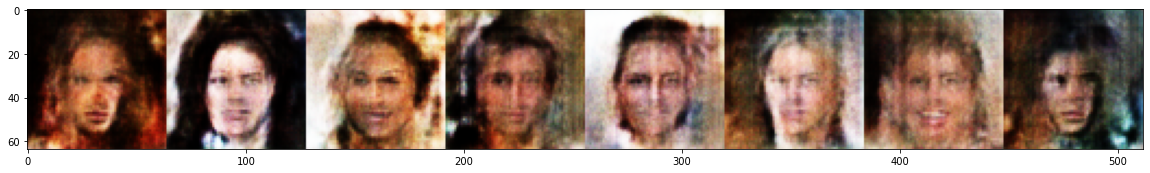

[1/3 - 5085/5086] Loss_D: 0.4138 Loss_G: 4.7701


<Figure size 432x288 with 0 Axes>

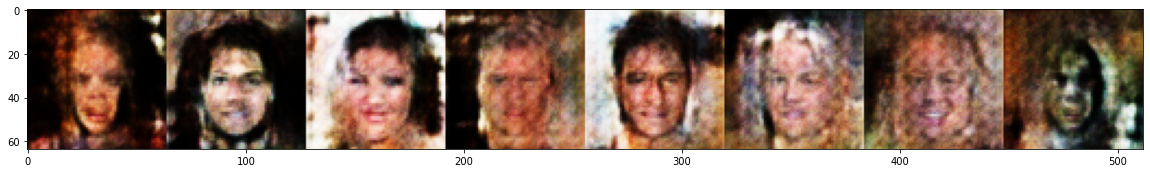

------------------------------
[2/3 - 0/5086] Loss_D: 0.8472 Loss_G: 2.4149


<Figure size 432x288 with 0 Axes>

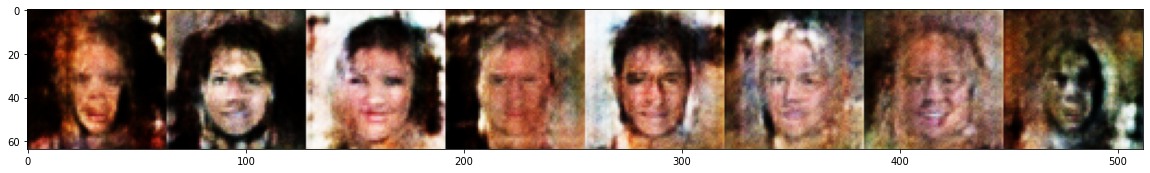

[2/3 - 1017/5086] Loss_D: 0.5255 Loss_G: 2.5154


<Figure size 432x288 with 0 Axes>

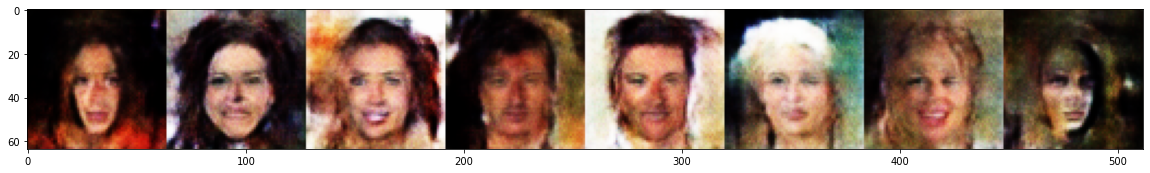

[2/3 - 2034/5086] Loss_D: 0.7407 Loss_G: 4.3379


<Figure size 432x288 with 0 Axes>

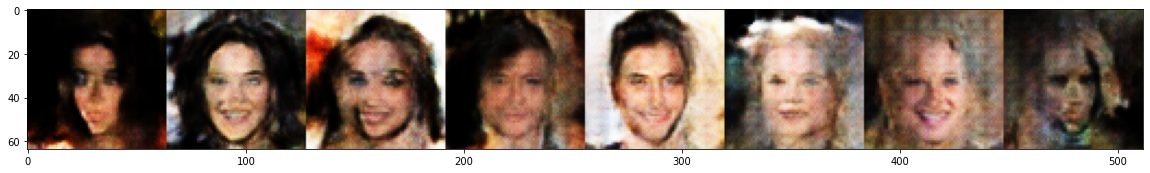

[2/3 - 3051/5086] Loss_D: 0.3586 Loss_G: 4.5581


<Figure size 432x288 with 0 Axes>

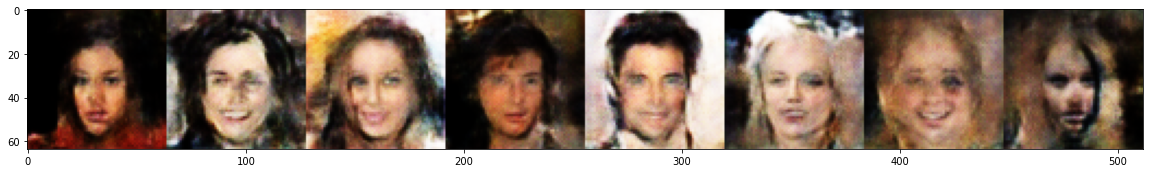

[2/3 - 4068/5086] Loss_D: 1.3833 Loss_G: 7.5486


<Figure size 432x288 with 0 Axes>

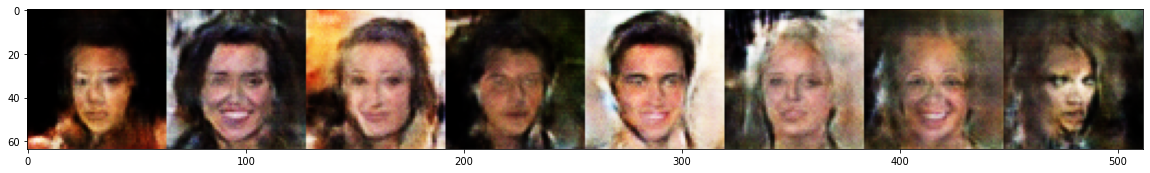

[2/3 - 5085/5086] Loss_D: 0.6397 Loss_G: 4.0460


<Figure size 432x288 with 0 Axes>

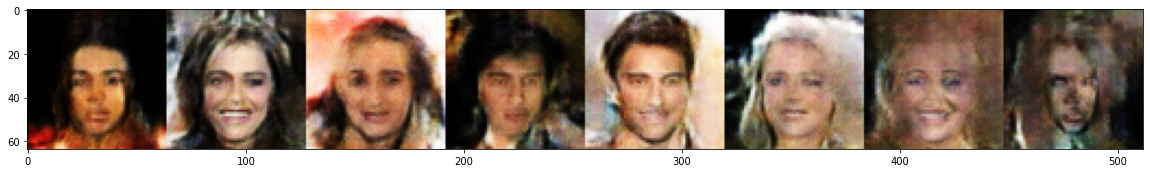

------------------------------
[3/3 - 0/5086] Loss_D: 1.0334 Loss_G: 1.9781


<Figure size 432x288 with 0 Axes>

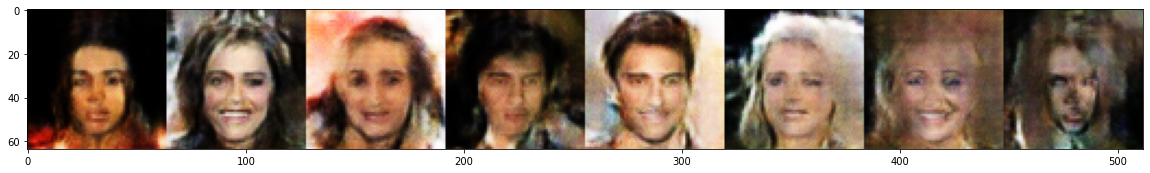

[3/3 - 1017/5086] Loss_D: 0.4059 Loss_G: 4.6559


<Figure size 432x288 with 0 Axes>

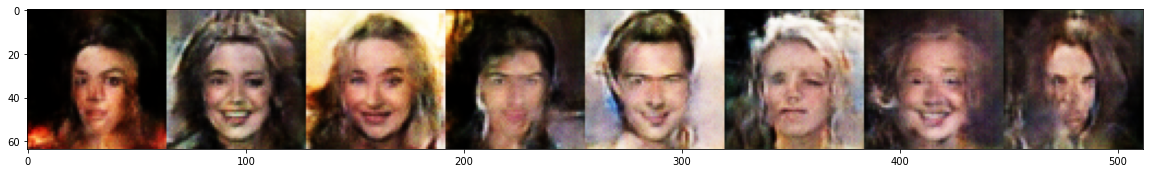

[3/3 - 2034/5086] Loss_D: 0.3692 Loss_G: 3.4641


<Figure size 432x288 with 0 Axes>

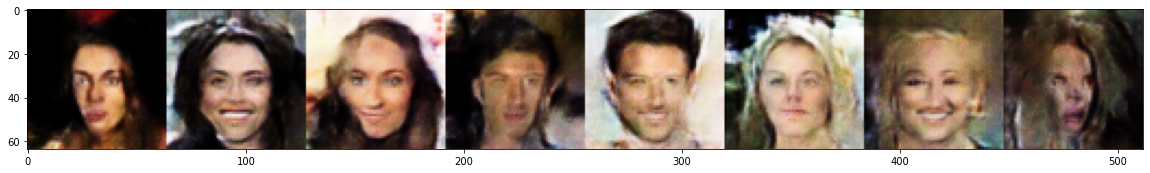

[3/3 - 3051/5086] Loss_D: 0.0492 Loss_G: 4.8108


<Figure size 432x288 with 0 Axes>

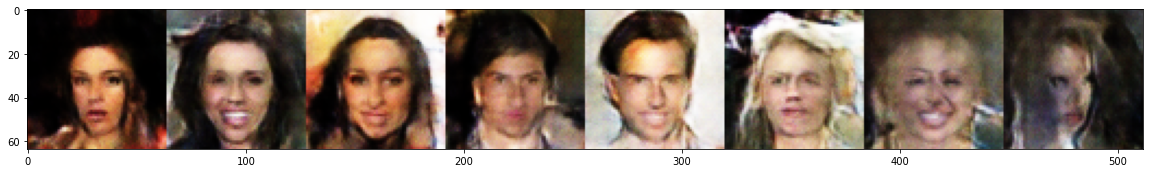

[3/3 - 4068/5086] Loss_D: 0.1630 Loss_G: 3.5586


<Figure size 432x288 with 0 Axes>

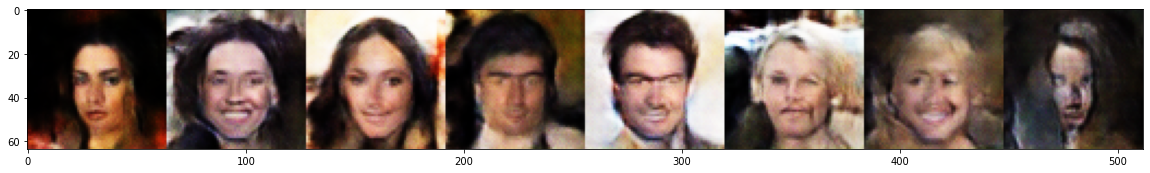

[3/3 - 5085/5086] Loss_D: 0.2452 Loss_G: 7.2071


<Figure size 432x288 with 0 Axes>

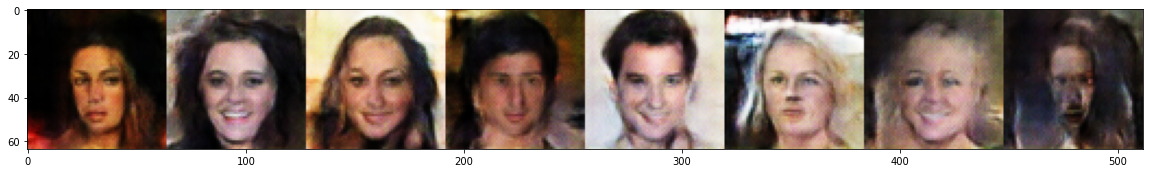

------------------------------
avg loss d 0.2452368438243866
avg loss d 7.2071027755737305
avg time 1463.782770872116 secs


<Figure size 432x288 with 0 Axes>

In [ ]:
from tqdm import tqdm
import time

log_step = int(len(dataset) * 0.2)
t = time.time()
G_losses = []
D_losses = []
for epoch in range(start_epoch, max_epoch + 1):
    loader = enumerate(dataset)
    d_loss_list = []
    g_loss_list = []
    for i, (imgs, _) in loader:
      with torch.autograd.set_detect_anomaly(True):
        loss_temp = {
            'err_d': [], # error_disciminator 
            'err_g': []  # error_generator
        }
        imgs = imgs.to(device)
        
        # ========== Update Discriminator ==========
        # ---------- You Should Modify ----------
        net_d.zero_grad()
        
        # throw real image into discirminator
        #real = imgs
        #b_size = imgs.size(0)
        label = real_label #torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = net_d(imgs).view(-1)
        err_dreal = criterion(output,label)
        #err_dreal.backward()
        # generate fake image and throw into discirminator
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = net_g(noise)
        label =fake_label #.fill_(fake_label) next.detach()
        output = net_d(fake_imgs).view(-1)
        err_dfake = criterion(output,label)
        #err_dfake.backward()
        # calculate loss
        err_d = err_dfake+err_dreal
        err_d.backward()
        loss_temp['err_d'].append(err_d.item())
        optim_d.step()
        
        # ========== Update Generator ==========
        # ---------- You Should Modify ----------
        net_g.zero_grad()
        
        # throw real image into discirminator
        
        label = real_label #label.fill_(real_label)
        # throw fake image into discirminator
        
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = net_g(noise)
        output = net_d(fake_imgs).view(-1)
        # ---------- You Should Modify ----------
        err_g = criterion(output, label)
        err_g.backward()
        loss_temp['err_g'].append(err_g.item())
        optim_g.step()
        
        if i % log_step == 0:
            print('[{}/{} - {}/{}] Loss_D: {:.4f} Loss_G: {:.4f}'.format( # y_d: {:.4f} / {:.4f}
                epoch, max_epoch, i, len(dataset),
                err_d.item(), err_g.item(),# y_d_real, y_d_fake#, y_g_real, y_g_fake
            ))
        
            fix_fake_imgs = net_g(fixed_noise).cpu().detach()
            plot_imgs(fix_fake_imgs[:8], True, file_name='out_imgs/e{:02}.png'.format(epoch))
        G_losses.append(err_g.item())
        D_losses.append(err_d.item())
    print('-' * 30)
    l_d = sum(loss_temp['err_d']) / len(loss_temp['err_d'])
    l_g = sum(loss_temp['err_g']) / len(loss_temp['err_g'])
    d_loss_list.append(l_d)
    g_loss_list.append(l_g)
print('avg loss d', sum(d_loss_list) / len(d_loss_list))
print('avg loss d', sum(g_loss_list) / len(g_loss_list))
t = time.time() - t
print('avg time', t / max_epoch, 'secs')


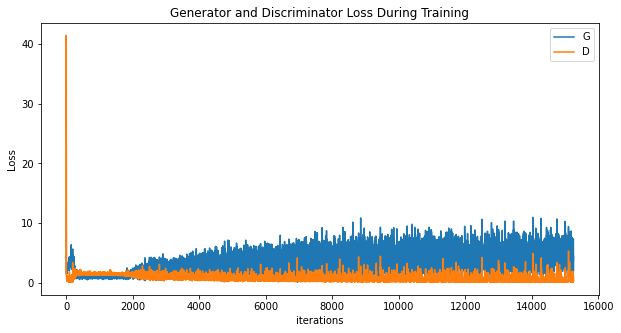

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

https://github.com/AlexiaJM/Deep-learning-with-cats/issues/11

https://github.com/pytorch/pytorch/issues/1768

https://clay-atlas.com/blog/2019/10/24/pytorch-%E6%95%99%E5%AD%B8-image-dcgan-%E5%88%A9%E7%94%A8%E7%94%9F%E6%88%90%E5%B0%8D%E6%8A%97%E7%B6%B2%E8%B7%AF%E7%94%9F%E6%88%90%E5%9C%96%E7%89%87/


## Your Task(Important)

**這段很重要打中文**  
這個 lab 屬於 bouns，需要你們對 GAN 做出改善（根據論文、網路上的 code），主要是照 DCGAN 的框架下改動，最基本的是將 DCGAN 實現出來

主要修改的方向，我有提供 SELU 和 relativistic GAN 兩個方向，你可以實作這兩個，可以得到共 50 分的配分，以下有一些不同的選項可以選擇，你會拿到不同的分數

任務：
- 用 SELU 當作 model 的 activation，並補上正確的 權重初始化方法（weight initialization) **(20 scores)**
- 修改 loss function，用 Relativistic GAN 的方法(RSGAN 或 RaSGAN 都可以)，詳情請務必參考[官方的 GitHub Code](https://github.com/AlexiaJM/RelativisticGAN#to-add-relativism-to-your-own-gans-in-pytorch-you-can-use-pieces-of-code-from-below) **(20 scores)**
- [必要] 你的任何發現、數個方法的比較或**詳細的說明** **(10 scores)**
- **任何** GAN 的改進也非常歡迎 (WGAN, gradient penalty, AAE...) **(可以取代上面的任意分數，還能獲得最多額外 10 分)**

請在這裡說明你要修改的項目：DCGAN model + Relativistic GAN loss

### 我應該做多少努力
- 假設你補上 DCGAN 的 activation + loss function，加上清楚說明 >> **25 分**
- 修改成 SELU activation，Relativistic GAN loss function 失敗，未能清楚說明 >> **35 分**
- 修改成 SELU activation + Relativistic GAN loss，清楚說明 >> **50 分**
- 把架構改成 WGAN + Relativistic GAN loss，加上 gradient penalty，清楚說明 >> **60 分**

DCGAN  的部分  首先調成整selu  裡面已經內含有batcnorm  但是weightinitial 需要調整成
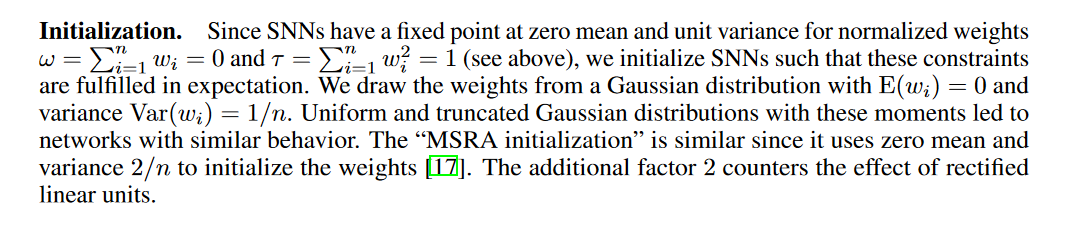

其原因是因為網路能夠快速收斂，並且不會產生梯度消失及爆炸的問題

下面的部分是針對將relu更改成selu以及relativistic GAN 部分
失敗原因是因為 BCElogitloss  同時處理exp及logarithm時不穩定，
有很高的機會會產生接近1的數字，但是卻有很少機會產生零的數字
然而單獨使用logit的情況下，由於使用log-sum-exp，因此比較不會產生這個問題
Cited by https://github.com/soumith/ganhacks/issues/36

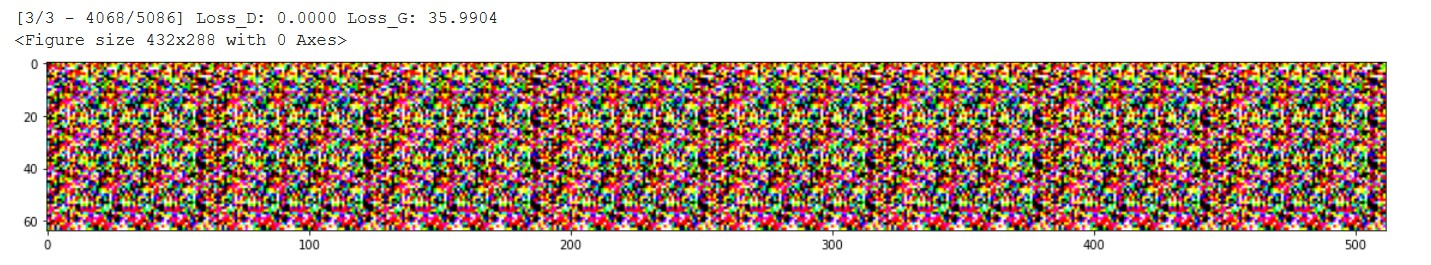

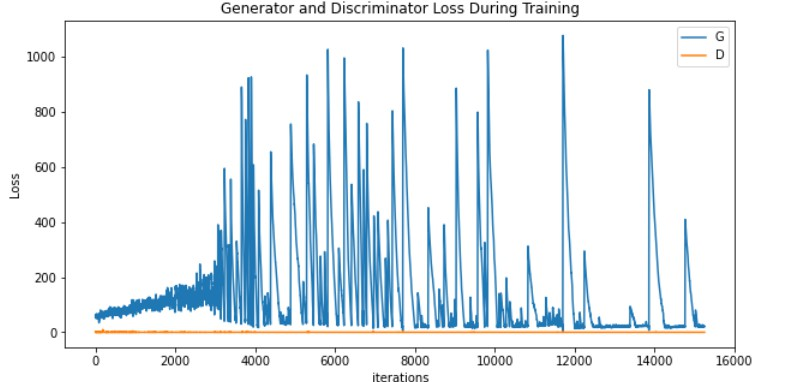